In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [5]:
import keras
import keras.backend as K
import keras.layers as layers
from keras.models import Model
from keras.utils import to_categorical
from keras import callbacks

Using TensorFlow backend.


In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [11]:
import util, defs

In [12]:
f_bg = np.load('sept10/particles_jj.npz')
bg_jets = f_bg['jets']
bg_consts = f_bg['constituents'][:,:defs.N_CONST]

f_sig = np.load('sept10/particles_yz.npz')
sig_jets = f_sig['jets']
sig_photons = f_sig['photons']
sig_consts = f_sig['constituents'][:,:defs.N_CONST]

bg_pass = bg_jets[:,3]>defs.JET_MASS_MIN
sig_pass = sig_jets[:,3]>defs.JET_MASS_MIN

bg_jets = bg_jets[bg_pass]
bg_consts = bg_consts[bg_pass]
sig_jets = sig_jets[sig_pass]
sig_consts = sig_consts[sig_pass]

sig_photons = sig_photons[sig_pass]

bg_consts[:,:,0][bg_consts[:,:,0]<defs.MIN_PT] = 0
sig_consts[:,:,0][sig_consts[:,:,0]<defs.MIN_PT] = 0


nc_bg = np.sum(bg_consts[:,:,0]>0, axis=-1)
nc_sig = np.sum(sig_consts[:,:,0]>0, axis=-1)

#bg_consts = bg_consts[nc_bg>2]
#bg_jets = bg_jets[nc_bg>2]
#sig_consts = sig_consts[nc_sig>2]
#sig_jets = sig_jets[nc_sig>2]

#nc_bg = np.sum(bg_consts[:,:,0]>0, axis=-1)
#nc_sig = np.sum(sig_consts[:,:,0]>0, axis=-1)
    
print(bg_consts.shape)
print(sig_consts.shape)

(173392, 64, 3)
(128377, 64, 3)


In [91]:
sig_photons.shape

(128377, 3)

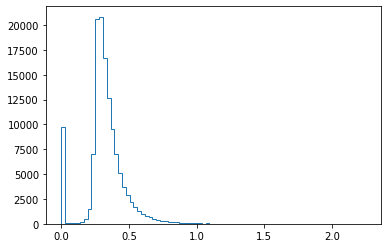

In [14]:
plt.hist(sig_photons[:,0], histtype='step', bins=80);

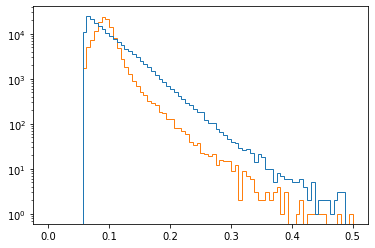

In [15]:
plt.hist([bg_jets[:,3], sig_jets[:,3]], histtype='step', bins=80, range=(0,0.5));
plt.yscale('log');

Text(0, 0.5, '∆R(jet, photon)')

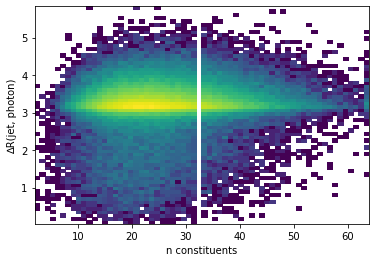

In [16]:
from matplotlib.colors import LogNorm
plt.hist2d(nc_sig, np.sqrt((sig_photons[:,1]-sig_jets[:,1])**2 + (sig_photons[:,2]-sig_jets[:,2])**2), bins=defs.N_CONST, norm=LogNorm());
plt.xlabel("n constituents")
plt.ylabel("∆R(jet, photon)")

Text(0, 0.5, 'jet mass')

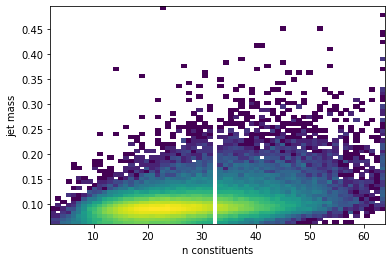

In [17]:
plt.hist2d(nc_sig, sig_jets[:,3], bins=defs.N_CONST, norm=LogNorm());
plt.xlabel("n constituents")
plt.ylabel("jet mass")

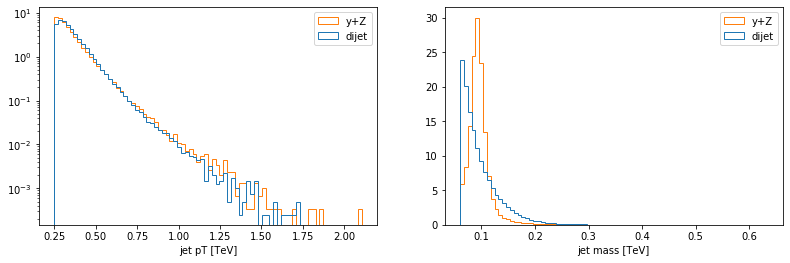

In [18]:
plt.figure(figsize=plt.figaspect(0.3))
plt.subplot(121)
h_sig = plt.hist([bg_jets[:,0], sig_jets[:,0]], histtype='step', bins=80, density=True, label=['dijet','y+Z']);
plt.xlabel("jet pT [TeV]");
plt.yscale('log');
plt.legend()
plt.subplot(122)
plt.hist([bg_jets[:,3], sig_jets[:,3]], histtype='step', bins=80, density=True, label=['dijet', 'y+Z']);
plt.xlabel("jet mass [TeV]");
plt.legend();

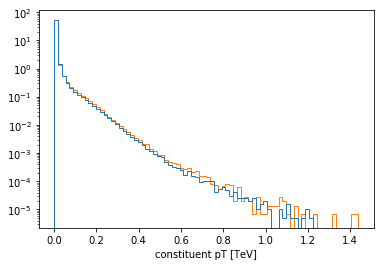

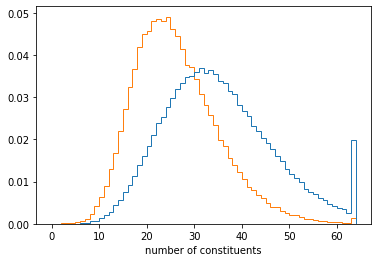

In [19]:
plt.hist([bg_consts[:,:,0].flatten(), sig_consts[:,:,0].flatten()], histtype='step', bins=80, density=True);
plt.yscale('log')
plt.xlabel('constituent pT [TeV]');
plt.figure()
plt.hist([nc_bg, nc_sig], histtype='step', bins=64, range=(0,64), density=True);
plt.xlabel("number of constituents");

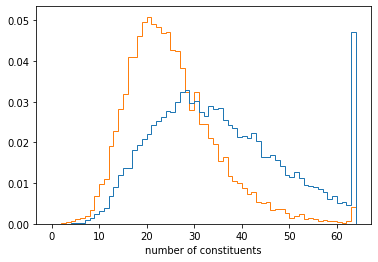

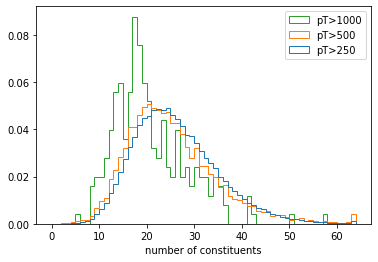

In [20]:
nc_bg500 = np.sum(bg_consts[:,:,0][bg_jets[:,0]>0.5]>0, axis=-1)
nc_sig500 = np.sum(sig_consts[:,:,0][sig_jets[:,0]>0.5]>0, axis=-1)
plt.hist([nc_bg500, nc_sig500], histtype='step', bins=64, range=(0,64), density=True);
plt.xlabel("number of constituents");
plt.figure()
nc_bg1000 = np.sum(bg_consts[:,:,0][bg_jets[:,0]>1]>0, axis=-1)
nc_sig1000 = np.sum(sig_consts[:,:,0][sig_jets[:,0]>1]>0, axis=-1)
plt.hist([nc_sig, nc_sig500, nc_sig1000], histtype='step', bins=64, range=(0,64), density=True, label=['pT>250','pT>500','pT>1000']);
plt.xlabel("number of constituents");
plt.legend();

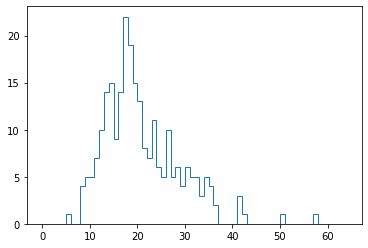

In [21]:
plt.hist(nc_sig1000, histtype='step', bins=64, range=(0,64));

In [22]:
(X_train, y_train), (X_val, y_val) = util.format_dataset(bg_consts, sig_consts,
                                                         validation_fraction=defs.VALIDATION_FRACTION)
X_train.shape

(218242, 64, 3)

In [23]:
X_val.shape

(38512, 64, 3)

In [24]:
def gen_data(X, y, batch_size=32, shuffle_particles=True):
    idxs = np.arange(X.shape[0])
    nbatch = int(X.shape[0]//batch_size)
    
    pidxs = np.arange(X.shape[1])
    
    while True:
        # shuffle event indices
        np.random.shuffle(idxs)
        
        for ibatch in range(nbatch):
            bidxs = idxs[ibatch*batch_size:(ibatch+1)*batch_size]
            
            Xb = X[bidxs]
            yb = y[bidxs]
            
            # shuffle particle indices
            if shuffle_particles:
                np.random.shuffle(pidxs)
                Xb = Xb[:,pidxs]
                
            yield (Xb, yb)

In [25]:
def mk_HL_calc(n_const):
    model_input = layers.Input((n_const, 3))
    x1 = util.JetVector()(model_input)
    x2 = util.JetECF()(model_input)
    d2 = layers.Lambda(lambda x: x[:,3:4]/100.)(x2) # NB: scaling D2 by 1/100
    model_output = layers.Concatenate(axis=-1)([x1,d2])
    model = Model(model_input, model_output)
    return model
hl_calc = mk_HL_calc(X_train.shape[1])
XH_train = hl_calc.predict(X_train, batch_size=256)
XH_val = hl_calc.predict(X_val, batch_size=256)

In [26]:
preds_shuff = next(gen_data(X_train[:4096], y_train[:4096], batch_size=4096))[0]
XH_train_shuff = hl_calc.predict(preds_shuff)

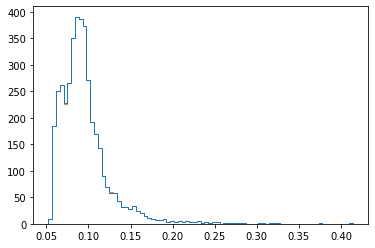

In [27]:
plt.hist([XH_train[:4096,3], XH_train_shuff[:4096,3]], histtype='step', bins=80);

In [28]:
hl_calc_trunc = mk_HL_calc(32)
XH_train_trunc = hl_calc_trunc.predict(X_train[:,:32], batch_size=256)

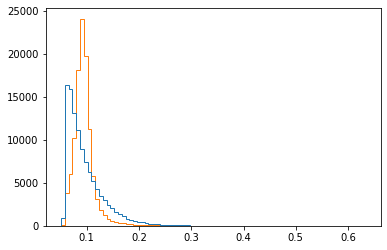

In [29]:
plt.hist([XH_train[:,3][y_train==0],XH_train[:,3][y_train==1]], histtype='step', bins=80);

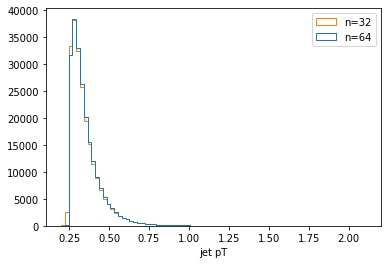

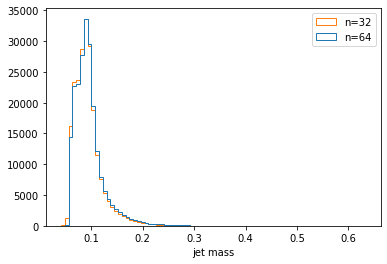

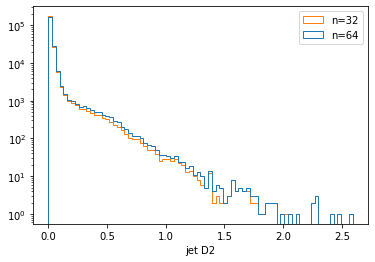

In [30]:
plt.hist([XH_train[:,0], XH_train_trunc[:,0]], histtype='step', bins=80, label=['n=%d'%defs.CLUSTER_ARGS['ntrk'],'n=32']);
plt.xlabel("jet pT")
plt.legend();
plt.figure()
plt.hist([XH_train[:,3], XH_train_trunc[:,3]], histtype='step', bins=80, label=['n=%d'%defs.CLUSTER_ARGS['ntrk'],'n=32']);
plt.xlabel("jet mass")
plt.legend();
plt.figure()
plt.hist([XH_train[:,4], XH_train_trunc[:,4]], histtype='step', bins=80, label=['n=%d'%defs.CLUSTER_ARGS['ntrk'],'n=32']);
plt.xlabel("jet D2")
plt.legend();
plt.yscale('log')

In [31]:
def mk_benchmark_LL(n_const, n_layers=3, n_units=256, dropout=None,
                    res=False, n_res_units=256, batch_norm=False):
    classifier_input = layers.Input((n_const, 3))
    
    def format_constituents(x):
        pt,eta,phi = tf.split(x, 3, axis=-1)
        phi_sin = tf.sin(phi)
        phi_cos = tf.cos(phi)
        return tf.concat([pt,eta,phi_sin,phi_cos], axis=-1)
    
    x = layers.Lambda(format_constituents)(classifier_input)
    x = layers.Flatten()(x)
    
    if res:
        x = layers.Dense(n_units, activation='relu')(x)
        if batch_norm:
            x = layers.BatchNormalization()(x)
        if dropout:
            x = layers.Dropout(dropout)(x)
        
        for _ in range(n_layers-1):
            y = layers.Dense(n_res_units, activation='relu')(x)
            if batch_norm:
                y = layers.BatchNormalization()(y)
            if dropout:
                y = layers.Dropout(dropout)(y)
            y = layers.Dense(n_units)(y)
            x = layers.add([x,y])
            x = layers.Activation('relu')(x)
            if batch_norm:
                x = layers.BatchNormalization()(x)
            if dropout:
                x = layers.Dropout(dropout)(x)
            
    else:
        for _ in range(n_layers):
            x = layers.Dense(n_units, activation='relu')(x)
            if dropout:
                x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(1, activation='sigmoid')(x)
    
    classifier_output = x
    
    classifier = Model(classifier_input, classifier_output)
    
    classifier.compile(optimizer='adam', loss='binary_crossentropy')
    
    classifier_aug_input = layers.Input((n_const, 3))
    x_aug = util.RandomizePhi()(classifier_aug_input)
    classifier_aug_output = classifier(x_aug)
    classifier_augmented = Model(classifier_aug_input, classifier_aug_output)
    classifier_augmented.compile(optimizer='adam', loss='binary_crossentropy')
    
    return classifier, classifier_augmented

In [32]:
K.clear_session()

benchmark_LL, benchmark_LL_aug = mk_benchmark_LL(defs.N_CONST, **defs.BENCHMARK_LL_ARGS)

benchmark_LL_nonaug = benchmark_LL
benchmark_LL = benchmark_LL_aug

benchmark_LL.h = util.HistoryCB(val_data=(X_val, y_val))

In [33]:
benchmark_LL_nonaug.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 3)             0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 64, 4)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
__________

In [ ]:
epochs = 200

batch_size = 128

shuffle_particles = False

learning_rate = 1e-4

K.set_value(benchmark_LL.optimizer.lr, learning_rate)

stopping = callbacks.EarlyStopping(monitor='val_loss', patience=32, verbose=2,
                                   mode='min', restore_best_weights=True)

try:
    #benchmark_LL.fit(X_train, y_train,
    #                 validation_data=(X_val, y_val),
    #                 callbacks=[benchmark_LL.h, stopping],
    #                 batch_size=batch_size,
    #                 epochs=epochs
    #                )
    benchmark_LL.fit_generator(gen_data(X_train, y_train,
                                        batch_size=batch_size,
                                        shuffle_particles=shuffle_particles),
                               validation_data=gen_data(X_val, y_val,
                                                         batch_size=batch_size,
                                                        shuffle_particles=shuffle_particles),
                               callbacks=[benchmark_LL.h, stopping],
                               steps_per_epoch=X_train.shape[0]//batch_size,
                               validation_steps=X_val.shape[0]//batch_size,
                               epochs=epochs
                              )
except KeyboardInterrupt:
    pass

Epoch 1/200
1705/1705 [==============================] - 13s 8ms/step - loss: 0.5892 - val_loss: 0.5871
Epoch 2/200
1705/1705 [==============================] - 13s 8ms/step - loss: 0.5886 - val_loss: 0.5857
Epoch 3/200
1705/1705 [==============================] - 13s 8ms/step - loss: 0.5886 - val_loss: 0.5813
Epoch 4/200
1705/1705 [==============================] - 13s 8ms/step - loss: 0.5880 - val_loss: 0.5862
Epoch 5/200
1705/1705 [==============================] - 13s 8ms/step - loss: 0.5875 - val_loss: 0.5859
Epoch 6/200
1705/1705 [==============================] - 13s 8ms/step - loss: 0.5878 - val_loss: 0.5845
Epoch 7/200
1705/1705 [==============================] - 13s 8ms/step - loss: 0.5871 - val_loss: 0.5831
Epoch 8/200
1705/1705 [==============================] - 13s 8ms/step - loss: 0.5871 - val_loss: 0.5864
Epoch 9/200
1705/1705 [==============================] - 13s 8ms/step - loss: 0.5867 - val_loss: 0.5871
Epoch 10/200
1705/1705 [==============================] - 13s 8m

1705/1705 [==============================] - 13s 8ms/step - loss: 0.5590 - val_loss: 0.5550
Epoch 80/200
1705/1705 [==============================] - 13s 8ms/step - loss: 0.5587 - val_loss: 0.5551
Epoch 81/200
1705/1705 [==============================] - 14s 8ms/step - loss: 0.5580 - val_loss: 0.5543
Epoch 82/200
1705/1705 [==============================] - 13s 8ms/step - loss: 0.5572 - val_loss: 0.5533
Epoch 83/200
1705/1705 [==============================] - 13s 8ms/step - loss: 0.5566 - val_loss: 0.5546
Epoch 84/200
1705/1705 [==============================] - 13s 8ms/step - loss: 0.5558 - val_loss: 0.5514
Epoch 85/200
1705/1705 [==============================] - 13s 8ms/step - loss: 0.5558 - val_loss: 0.5502
Epoch 86/200
1705/1705 [==============================] - 13s 8ms/step - loss: 0.5543 - val_loss: 0.5502
Epoch 87/200
 520/1705 [========>.....................] - ETA: 8s - loss: 0.5516

Validation AUC: 0.8346157536575826


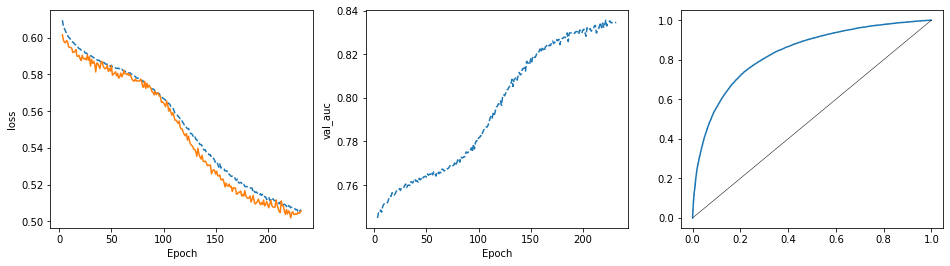

In [42]:
benchmark_LL.h.plot(['loss', 'val_auc', 'roc'], nskip=2,
                    figsize=plt.figaspect(0.25))
from sklearn.metrics import roc_auc_score
print("Validation AUC:", roc_auc_score(y_val, benchmark_LL.predict(X_val)))

In [31]:
save_model = False

if save_model:
    benchmark_LL_nonaug.save('model_benchmark_LL.h5')

In [36]:
def mk_benchmark_HL(n_feature=5, n_layers=3, n_units=256, dropout=None):
    classifier_input = layers.Input((n_feature,))
    
    x = classifier_input
    
    def format_jets(x):
        features = tf.split(x, n_feature, axis=-1)
        phi = features[2]
        phi_sin = tf.sin(phi)
        phi_cos = tf.cos(phi)
        return tf.concat(features[:2]+features[3:] + [phi_sin,phi_cos], axis=-1)
    
    x = layers.Lambda(format_jets)(x)
    
    for _ in range(n_layers):
        x = layers.Dense(n_units, activation='relu')(x)
        if dropout:
            x = layers.Dropout(dropout)(x)
    
    x = layers.Dense(1, activation='sigmoid')(x)
    
    classifier_output = x
    
    classifier = Model(classifier_input, classifier_output)
    
    classifier.compile(optimizer='adam', loss='binary_crossentropy')
    
    return classifier

In [37]:
#K.clear_session()
benchmark_HL = mk_benchmark_HL(**defs.BENCHMARK_HL_ARGS)

benchmark_HL.h = util.HistoryCB(val_data=(XH_val, y_val))

In [38]:
benchmark_HL.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 5)                 0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 6)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 384)               2688      
_________________________________________________________________
dropout_6 (Dropout)          (None, 384)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 384)               147840    
_________________________________________________________________
dropout_7 (Dropout)          (None, 384)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 384)               147840    
__________

In [ ]:
epochs = 32

batch_size = 128

learning_rate = 3e-4

K.set_value(benchmark_HL.optimizer.lr, learning_rate)

stopping = callbacks.EarlyStopping(monitor='val_loss', patience=16, verbose=1,
                                   mode='min', restore_best_weights=True)

try:
    benchmark_HL.fit(XH_train, y_train,
                     validation_data=(XH_val, y_val),
                     callbacks=[benchmark_HL.h, stopping],
                     batch_size=batch_size,
                     epochs=epochs
                    )
except KeyboardInterrupt:
    pass

Train on 218242 samples, validate on 38512 samples
Epoch 1/32
218242/218242 [==============================] - 10s 48us/step - loss: 0.6938 - val_loss: 0.6928
Epoch 2/32
218242/218242 [==============================] - 10s 46us/step - loss: 0.6911 - val_loss: 0.6804
Epoch 3/32
218242/218242 [==============================] - 10s 46us/step - loss: 0.6612 - val_loss: 0.6285
Epoch 4/32
218242/218242 [==============================] - 10s 47us/step - loss: 0.6284 - val_loss: 0.5923
Epoch 5/32
218242/218242 [==============================] - 10s 46us/step - loss: 0.5978 - val_loss: 0.5575
Epoch 6/32
218242/218242 [==============================] - 10s 46us/step - loss: 0.5774 - val_loss: 0.5498
Epoch 7/32
218242/218242 [==============================] - 10s 46us/step - loss: 0.5709 - val_loss: 0.5426
Epoch 8/32
218242/218242 [==============================] - 10s 46us/step - loss: 0.5681 - val_loss: 0.5440
Epoch 9/32
218242/218242 [==============================] - 10s 46us/step - loss: 0.5

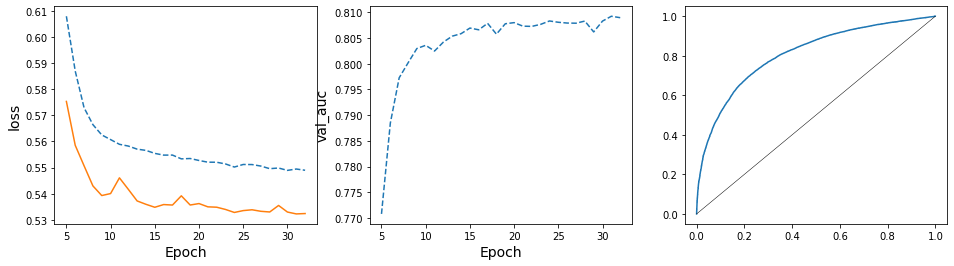

In [36]:
benchmark_HL.h.plot(['loss', 'val_auc', 'roc'], nskip=4, figsize=plt.figaspect(0.25))

In [40]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, benchmark_HL.predict(XH_val))

0.8068197742260534

In [38]:
save_model = False

if save_model:
    benchmark_LL.save('model_benchmark_HL.h5')

In [63]:
import energyflow as ef
from energyflow.archs import PFN
from keras import optimizers

In [93]:
import energyflow as ef
from energyflow.archs import PFN

#learning_rate = 1e-4

print(X_train.shape[-1])
Phi_sizes, F_sizes = (100, 128), (100, 100)
#myadam = optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#pfn = PFN(input_dim=X_train.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes,optimizer=myadam,F_dropouts=0.25)
pfn = PFN(input_dim=X_train.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

3
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 3)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    400         input[0][0]                      
__________________________________________________________________________________________________
activation_69 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 128)    12928       activation_69[0][0]              
__________________________________________________________________________________________________
mask (La

In [94]:
num_epoch = 200
batch_size = 256
pfn.fit(X_train, to_categorical(y_train,2),
          epochs=num_epoch,
          batch_size=batch_size,
          validation_data=(X_val, to_categorical(y_val,2)),
          verbose=1)

Train on 218242 samples, validate on 38512 samples
Epoch 1/200
218242/218242 [==============================] - 20s 92us/step - loss: 0.9605 - acc: 0.5737 - val_loss: 0.7269 - val_acc: 0.5934
Epoch 2/200
218242/218242 [==============================] - 10s 47us/step - loss: 0.6655 - acc: 0.6361 - val_loss: 0.6510 - val_acc: 0.6441
Epoch 3/200
218242/218242 [==============================] - 10s 47us/step - loss: 0.6341 - acc: 0.6550 - val_loss: 0.6111 - val_acc: 0.6681
Epoch 4/200
218242/218242 [==============================] - 10s 47us/step - loss: 0.6203 - acc: 0.6636 - val_loss: 0.6158 - val_acc: 0.6684
Epoch 5/200
218242/218242 [==============================] - 10s 48us/step - loss: 0.6126 - acc: 0.6680 - val_loss: 0.6165 - val_acc: 0.6731
Epoch 6/200
218242/218242 [==============================] - 10s 48us/step - loss: 0.6066 - acc: 0.6741 - val_loss: 0.5979 - val_acc: 0.6834
Epoch 7/200
218242/218242 [==============================] - 10s 48us/step - loss: 0.6040 - acc: 0.6748

218242/218242 [==============================] - 10s 48us/step - loss: 0.5810 - acc: 0.6933 - val_loss: 0.5834 - val_acc: 0.6928
Epoch 59/200
218242/218242 [==============================] - 10s 48us/step - loss: 0.5810 - acc: 0.6934 - val_loss: 0.5799 - val_acc: 0.6931
Epoch 60/200
218242/218242 [==============================] - 11s 48us/step - loss: 0.5804 - acc: 0.6939 - val_loss: 0.5820 - val_acc: 0.6945
Epoch 61/200
218242/218242 [==============================] - 10s 48us/step - loss: 0.5804 - acc: 0.6941 - val_loss: 0.5807 - val_acc: 0.6936
Epoch 62/200
218242/218242 [==============================] - 10s 47us/step - loss: 0.5803 - acc: 0.6939 - val_loss: 0.5794 - val_acc: 0.6958
Epoch 63/200
218242/218242 [==============================] - 10s 48us/step - loss: 0.5798 - acc: 0.6942 - val_loss: 0.5790 - val_acc: 0.6962
Epoch 64/200
218242/218242 [==============================] - 10s 48us/step - loss: 0.5798 - acc: 0.6937 - val_loss: 0.5814 - val_acc: 0.6926
Epoch 65/200
218242

218242/218242 [==============================] - 11s 48us/step - loss: 0.5761 - acc: 0.6969 - val_loss: 0.5826 - val_acc: 0.6961
Epoch 116/200
218242/218242 [==============================] - 11s 48us/step - loss: 0.5759 - acc: 0.6961 - val_loss: 0.5814 - val_acc: 0.6943
Epoch 117/200
218242/218242 [==============================] - 10s 48us/step - loss: 0.5758 - acc: 0.6969 - val_loss: 0.5809 - val_acc: 0.6955
Epoch 118/200
218242/218242 [==============================] - 10s 48us/step - loss: 0.5760 - acc: 0.6966 - val_loss: 0.5808 - val_acc: 0.6949
Epoch 119/200
218242/218242 [==============================] - 10s 48us/step - loss: 0.5756 - acc: 0.6975 - val_loss: 0.5777 - val_acc: 0.6974
Epoch 120/200
218242/218242 [==============================] - 10s 48us/step - loss: 0.5759 - acc: 0.6971 - val_loss: 0.5790 - val_acc: 0.6979
Epoch 121/200
218242/218242 [==============================] - 10s 47us/step - loss: 0.5755 - acc: 0.6964 - val_loss: 0.5803 - val_acc: 0.6968
Epoch 122/200

218242/218242 [==============================] - 10s 48us/step - loss: 0.5732 - acc: 0.6981 - val_loss: 0.5829 - val_acc: 0.6967
Epoch 173/200
218242/218242 [==============================] - 10s 48us/step - loss: 0.5732 - acc: 0.6986 - val_loss: 0.5829 - val_acc: 0.6976
Epoch 174/200
218242/218242 [==============================] - 10s 47us/step - loss: 0.5729 - acc: 0.6988 - val_loss: 0.5835 - val_acc: 0.6961
Epoch 175/200
218242/218242 [==============================] - 10s 48us/step - loss: 0.5731 - acc: 0.6989 - val_loss: 0.5825 - val_acc: 0.6970
Epoch 176/200
218242/218242 [==============================] - 10s 48us/step - loss: 0.5731 - acc: 0.6987 - val_loss: 0.5812 - val_acc: 0.6988
Epoch 177/200
218242/218242 [==============================] - 10s 47us/step - loss: 0.5730 - acc: 0.6989 - val_loss: 0.5839 - val_acc: 0.6969
Epoch 178/200
218242/218242 [==============================] - 10s 48us/step - loss: 0.5732 - acc: 0.6991 - val_loss: 0.5824 - val_acc: 0.6967
Epoch 179/200

(0.55, 0.72)

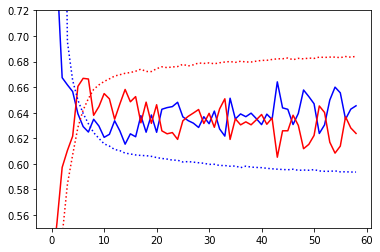

In [90]:
plt.plot(pfn.history.history['val_loss'],color='blue')
plt.plot(pfn.history.history['val_acc'],color='red')
plt.plot(pfn.history.history['loss'],color='blue',linestyle=":")
plt.plot(pfn.history.history['acc'],color='red',linestyle=":")
plt.ylim(0.55,0.72)

In [84]:
print("Validation AUC:", roc_auc_score(y_val, pfn.predict(X_val)[:,1]))

Validation AUC: 0.764001676124149
